## Librerías

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import cartopy.crs as ccrs	
import cartopy.feature 	
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib
import matplotlib.path as mpath
from scipy import signal
from scipy import stats
from scipy.fftpack import fft
import scipy
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

from wavelib import *
import sys

## Funciones

In [2]:
def trend_xarray(darray) :

    #Los parametros de la función son:darray instancia de Dataset y VAR la variable
    #que quiero del dataset
    
    #Apilo latitudes y longitudes
    darray_stack=darray.stack(points=[darray.dims[1], darray.dims[2]]) 
    
    #Arrays vacios para todos los tiempos y el primer punto de grilla
    trendarray = np.empty_like(darray_stack[0,:]) # Arrays vacios
    pval = np.empty_like(darray_stack[0,:])
    b = np.empty_like(darray_stack[0,:])
    
    #Ciclo para completar los array vacios. Indice k recorre el rango de los
    #tiempos de darray_stack (shape[1] es para seleccionar la dim del tiempo)
    for k in range(darray_stack.shape[1]):
        y = darray_stack[:, k] #y es todos los puntos de grilla del tiempo k
        [trendarray[k], b[k], r_va, pval[k], z] = stats.linregress(np.arange(len(darray_stack['time'])), y)    

    # Le regreso la forma de latxlon
    tend = np.reshape(trendarray, (len(darray[darray.dims[1]]), len(darray[darray.dims[2]]))) 
    pv_tend = np.reshape(pval, (len(darray[darray.dims[1]]), len(darray[darray.dims[2]])))
    interc = np.reshape(b, (len(darray[darray.dims[1]]), len(darray[darray.dims[2]])))
    return tend,pv_tend,interc

def del_trend(da):
    
    if (len(da['Verano (DJF)'].dims)==1):
       
        pend=[]
        interc=[]
        
        for key in KEYS:
            m,b,pv,rv,c1=stats.linregress(da[key]['time.year'],da[key])
            pend.append(m)
            interc.append(b)
            
        #Remuevo las variables temporales usadas en el ciclo
        del m,b,pv,rv,c1
        

        #(2) Calculo los valores de anomalía de precipitación según la regresión lineal
        #    pp'=m*año+b para cada estación, y los guardo en "arreglo_lineal"
        
        #Inicialización de lista vacía
        arreglo_lineal = []
        i=0
        
        for key in KEYS:
            a=pend[i]*da[key]['time.year']+interc[i]
            arreglo_lineal.append(a)
            i=i+1
        
        del a
        
    
        #(3) Ahora a los valores originales de anomalía se le resta la tendencia lineal y 
        #    se almacena en "anom_st"

        #Inicalización de lista vacia
        da_ST=[]
        i=0
        
        #Ciclo para iterar diccionarios y realizar los calculos
        for key in KEYS:
            da_ST.append(da[key]-arreglo_lineal[i])
            i=i+1
        
        da_ST=dict(zip(KEYS,da_ST))
        
        return da_ST
    
    else:

        pend=[]
        interc=[]
        
        print('Calculando pendiente y ordenada al origen de tendencia lineal')
        
        for key in KEYS:
            m,pv,b=trend_xarray(da[key])
            pend.append(m)
            interc.append(b)
        
        arreglo_lineal = []
        j=0
        
        print('Calculando valor de la regresión por punto de grilla y año')
        
        for key in KEYS:    
            a=[]
            for i in range(len(da[key]['time.year'])):
                year=int(da[key]['time.year'][i])
                a.append(pend[j]*year+interc[j])
            arreglo_lineal.append(a)
            j=j+1
        
        da_ST=[]
        i=0
        
        print('Restando regresión')
        
        for key in KEYS:
            da_ST.append(da[key]-arreglo_lineal[i])
            i=i+1
        
        da_ST=dict(zip(KEYS,da_ST))
        
        return da_ST

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def harmonic_signal(a, coef) :
    #hago analisis armonico y retengo los armonicos deseados
    N = np.shape(a)[0]
    time_axis = np.arange(1,N+1)
    ft = fft(a)     
    reconstructed_signal = np.zeros(N)    
    np.add (reconstructed_signal, ft[0] * np.ones(N), out = reconstructed_signal,
            casting='unsafe')
    # Adding the dc term explicitly makes the looping easier in the next step.    
    num_coefficients = coef   
    for k in range(num_coefficients):
        k += 1  # Bump by one since we already took care of the dc term.
        if k == N-k:
            np.add(reconstructed_signal, ft[k] * np.exp(1.0j*2 * np.pi * (k) * time_axis / N),
                    out = reconstructed_signal, casting = 'unsafe')
            # This catches the case where N is even and ensures we don't double-
            # count the frequency k=N/2.
        else:
            np.add(reconstructed_signal, ft[k] * np.exp(1.0j*2 * np.pi * (k) * time_axis / N),
                                           out = reconstructed_signal, casting = 'unsafe')
            np.add(reconstructed_signal, ft[N-k] * np.exp(1.0j*2 * np.pi * (N-k) * time_axis / N),
                                                  out = reconstructed_signal, casting = 'unsafe')    
            # In this case we're just adding a frequency component and it's
            # "partner" at minus the frequency    
    reconstructed_signal = reconstructed_signal / N
    return reconstructed_signal


def xr_corr(dict3D, dict1D, n=0):
    
    '''
    Función para calcular correlación de una serie temporal
    con cada punto de grilla de un netcdf (serie 1D y serie
    3D) usando la función corr de xarray. 
    
    Parámetros:
        dict3D: un diccionario ("estación":netcdf) con 4 elementos,
        un netcdf para cada estación del año.
        dict1D: un diccionario ("estación":serie temporal) con 4 elementos,
        una serie temporal para cada estación del año.
    
    Devuelve:
        un netcdf con las correlaciones por punto de grilla
    
    
    '''
    
    #Inicializo lista vacia
    corrs=[]
    
    for key in KEYS:
        
        ds3D=dict3D[key]
        ds1D=dict1D[key][n]
        
        corr=xr.corr(ds3D,ds1D,'time') 

        corrs.append(corr)
        
   
    corrs=dict(zip(KEYS,corrs))
    
    return corrs

def graf_corrs_stereo(var,VAR,comp=''):

    fig, ax = plt.subplots() 
    gs = gridspec.GridSpec(2,2)    
    #latitudes and longitudes to plot
    lon, lat = var['Verano (DJF)'][var['Verano (DJF)'].dims[1]],var['Verano (DJF)'][var['Verano (DJF)'].dims[0]]
    
    i=0
    for key in KEYS:   

        ax = plt.subplot(gs[i],projection=ccrs.SouthPolarStereo(central_longitude=300))

        #Pasamos las latitudes/longitudes del dataset a una reticula para graficar
        lons, lats = np.meshgrid(np.append(lon,360),lat)

        lev_inf = -0.6
        lev_sup = 0.6
        lev_int =0.1
        clevs = np.arange(lev_inf, lev_sup+lev_int, lev_int)

        crs_latlon = ccrs.PlateCarree()
        ax.set_extent([0,359.9, -90, 0], crs=crs_latlon)
        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        maximo = np.max(np.squeeze(var[key]))
        minimo = np.min(np.squeeze(var[key]))
        limite = np.max([np.abs(minimo),np.abs(maximo)])
        clevels = np.arange(-limite,(limite+limite*2/10),limite*2/10)
        ax.set_boundary(circle, transform=ax.transAxes)
        im=ax.contourf(lons, lats, add_cyclic_point(np.squeeze(var[key])),clevs,transform=crs_latlon,cmap='RdBu_r',extend='both')
        #ax.contour(lons, lats, add_cyclic_point(np.squeeze(var[key])),clevs,colors='k',transform=crs_latlon,extend='both')     
        #plt.colorbar(im,fraction=0.052, pad=0.04,shrink=0.8,aspect=12)
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.1)
        ax.gridlines(crs=crs_latlon, linewidth=0.3, linestyle='-')
        ax.set_title(str(key), fontsize=10)
        
        i=i+1
    cbar_ax = fig.add_axes([0.98, 0.1, 0.03, 0.8])        
    fig.colorbar(im, cax=cbar_ax,orientation='vertical')
    #fig.colorbar(im,orientation='vertical')

    fig.suptitle("Corr. componente {} y {} {} ".format(comp, VAR, PER))
    #Save in jpg
       
    fig.savefig(SALIDAS+'Correlacion_'+VAR+'_'+PER+'_'+comp+"_stereo.jpg", dpi=300, bbox_inches='tight')
    
    
def graf_corrs_Robinson(var,VAR, comp=''):
    
    #Tamaño para mapas del centro de Argentina
    fig, ax = plt.subplots()
    
    #Define grid for subplots
    gs = gridspec.GridSpec(2,2)     
    
    #latitudes and longitudes to plot
    lons, lats = np.meshgrid(var['Verano (DJF)'][var['Verano (DJF)'].dims[1]], 
                             var['Verano (DJF)'][var['Verano (DJF)'].dims[0]])
    
    #Definimos los niveles para los contornos (inferior, superior, longitud de los intervalos)
    #Si utilizamos las funciones ds.min ds.max podemos darnos una idea de cómo definirlos
    lev_inf = -0.6
    lev_sup = 0.6
    lev_int = 0.1
    clevs = np.arange(lev_inf, lev_sup+lev_int, lev_int)
    
    i=0
    for key in KEYS:
        
        #Proyección rectangular
        ax = plt.subplot(gs[i],projection=ccrs.Robinson())
        
        crs_latlon = ccrs.PlateCarree()
        #ax.set_extent([LON_OESTE_G, LON_ESTE_G, LAT_SUR_G, LAT_NOR_G], crs=crs_latlon)
        #ax.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='k')
        ax.add_feature(cartopy.feature.COASTLINE, alpha=.5)
        #ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.05)
        # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
        # states_provinces = cartopy.feature.NaturalEarthFeature(
          #  category='cultural',
          #  name='admin_1_states_provinces_lines',
          #  scale='10m',
          #  facecolor='none')
        
        #ax.add_feature(states_provinces, edgecolor='darkslategrey', linewidths=0.3)
        
        #im=ax.contourf(lons, lats, add_cyclic_point(np.squeeze(var[key])),cmap="RdBu_r", levels=clevs,extend='both',transform=crs_latlon)
        im=ax.contourf(lons, lats, var[key],cmap="RdBu_r", levels=clevs,extend='both',transform=crs_latlon)
        #ax.contour(lons, lats, pval[key],levels=[0.1],colors='k',linewidths=0.5 , transform=crs_latlon) 
        
        #ax.set_xticks(np.arange(0,358,100), crs=crs_latlon)
        #ax.set_yticks(np.arange(-88,88,100), crs=crs_latlon)
               
        #ax.set_xticks(np.arange(0,358,100))
        #ax.set_yticks(np.arange(-88,88,100))
        
        ax.grid(which='both', linewidth=0.3, linestyle='-')
        ax.tick_params(axis='both', which='major', labelsize=8)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.gridlines(linewidth=0.3, linestyle='-')
        
        ax.set_title(str(key), fontsize=10)
        
        COLOR='black'
    
        i=i+1
    
    cbar_ax = fig.add_axes([0.98, 0.1, 0.03, 0.8])
    
    fig.colorbar(im, cax=cbar_ax,orientation='vertical') 
    fig.suptitle("Corr. componente {} y {} {} ".format(comp, VAR, PER),fontsize=11)
    
    fig.savefig(SALIDAS+'Correlacion_'+VAR+'_'+PER+'_'+comp+"_Robinson.jpg", dpi=300, bbox_inches='tight')
    print ('Figura de correlacion_'+VAR+'_PP(CRU)_SinTendencia'+PER+' en '+SALIDAS)

## Constantes

In [3]:
# Para serie temporal de anomalias CENTRO ARGENTINA
LAT_SUR_M=-35
LAT_NOR_M=-26
LON_OESTE_M=294
LON_ESTE_M=299

#Para calculos CENTRO ARGENTINA
LAT_SUR=-42
LAT_NOR=-16
LON_OESTE=287
LON_ESTE=306

#Para graficar CENTRO ARGENTINA
LAT_SUR_G=-39
LAT_NOR_G=-19
LON_OESTE_G=290
LON_ESTE_G=303

#Periodo largo
ANIO_MIN1=1930
ANIO_MAX1=2016

#Periodo corto
ANIO_MIN2=1981
ANIO_MAX2=2010

#Periodo en formato
TIMEMIN1 = str(ANIO_MIN1)+'-01-01'
TIMEMAX1 = str(ANIO_MAX1)+'-12-31'

#Periodo en formato
TIMEMIN2 = str(ANIO_MIN2)+'-01-01'
TIMEMAX2 = str(ANIO_MAX2)+'-12-31'

#Periodo en el cual se calculará la media para las anomalías
TIMEMIN_MEDIA = '1951-01-01'
TIMEMAX_MEDIA = '1980-12-31'

#Path a los datos
DATOS_PP_GPCC='/datos/Datos_Dalia/precip.mon.total.v2018.nc'
DATOS_SST='/datos/Datos_Dalia/sst.mnmean.nc'
DATOS_PP_CRU='/datos/Datos_Dalia/cru_ts4.05.1901.2020.pre.dat.nc'
DATOS_GEOP='/datos/Datos_Dalia/geopotential_monthly_averaged.nc'
DATOS_MSLP='/datos/Datos_Dalia/mean_sea_level_pressure_monthly_averaged.nc'

#Path para guardar figuras
SALIDAS='/home/dalia.panza/Proy_IAI/Salidas/SSA/'

#Vector con nombres de las estaciones del año
KEYS=['Verano (DJF)', 'Otoño (MAM)', 'Invierno (JJA)', 'Primavera (SON)']

## Período

In [4]:
per=1

if (per==1):
    
    TIMEMIN=TIMEMIN1
    TIMEMAX=TIMEMAX1
    PER='(1930-2016)'
    
else:
    
    TIMEMIN=TIMEMIN2
    TIMEMAX=TIMEMAX2
    PER='(1981-2010)'

## Mapa de la región a analizar 

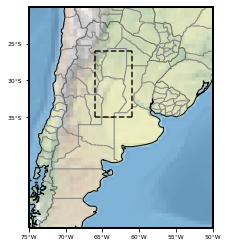

In [5]:
#Creamos la figura y definimos su tamaño
fig = plt.figure(figsize=(3.3, 5.3))

ax=plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
crs_latlon = ccrs.PlateCarree()
ax.set_extent([285,289, -50, -20], crs=crs_latlon)


#Agrego bordes de costas, países y provincias
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cartopy.feature.NaturalEarthFeature(
      category='cultural',
      name='admin_1_states_provinces_lines',
      scale='10m',
      facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')

ax.set_xticks([285, 290, 295,300,305, 310], crs=crs_latlon)
ax.set_yticks([-35,-30, -25], crs=crs_latlon)
ax.grid(which='both', linewidth=0.3, linestyle='-')
ax.tick_params(axis='both', which='major', labelsize=6)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.stock_img()
#Grafico cuadraditos 
ax.plot([294, 294], [-35,
-26],color='k', linestyle='--',alpha=0.9,
transform=ccrs.PlateCarree())
ax.plot([299, 299], [-35,
-26],color='k',
linestyle='--',alpha=0.9,transform=ccrs.PlateCarree())
ax.plot([294, 299], [-35,
-35],color='k',
linestyle='--',alpha=0.9,transform=ccrs.PlateCarree())
ax.plot([294, 299], [-26,
-26],color='k',
linestyle='--',alpha=0.9,transform=ccrs.PlateCarree())
    

fig.savefig(SALIDAS + 'Mapa.png', dpi=300, bbox_inches='tight')

## Lectura de datos

In [6]:
# Abro el archivo usando xarray
ds_pp = xr.open_dataset(DATOS_PP_GPCC)

#Recorte temporal y espacial
pp_recorte = ds_pp.sel(lat=slice(LAT_NOR, LAT_SUR), lon=slice(LON_OESTE,LON_ESTE))['precip']

del ds_pp

#Remuestreo los datos dividiendo por estaciones (DEF-MAM-JJA-SON)
pp_est = pp_recorte.resample(time="QS-DEC").sum()

pp_est={KEYS[0]:pp_est.sel(time=pp_est["time.month"]==12),
        KEYS[1]:pp_est.sel(time=pp_est["time.month"]==3),
        KEYS[2]:pp_est.sel(time=pp_est["time.month"]==6),
        KEYS[3]:pp_est.sel(time=pp_est["time.month"]==9)}

#Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
pp_est[KEYS[0]]=pp_est[KEYS[0]].sel(time=slice(pp_est[KEYS[0]]['time'][1],
                                                pp_est[KEYS[0]]['time'][-2]))





## Cálculo de anomalías

In [7]:
#Anomalía para cada punto de reticula

"""Para la serie original"""
pp_media = pp_recorte.sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                               lon=slice(LON_OESTE_M,LON_ESTE_M),
                               time=slice(TIMEMIN_MEDIA,TIMEMAX_MEDIA)).mean()
pp_anom =pp_recorte.sel(time=slice(TIMEMIN,TIMEMAX)) - pp_media

"""Por estación"""
#Inicializo lista vacia 
pp_est_anom=[]

#Ciclo para iterar en el diccionario de datos de pp
for key in KEYS:
    #Hago un recorte espacial para el centro de Arg y el periodo 51-80
    pp_media = pp_est[key].sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                               lon=slice(LON_OESTE_M,LON_ESTE_M),
                               time=slice(TIMEMIN_MEDIA,TIMEMAX_MEDIA)).mean()
    #A la lista vacía le agrego la anomalía para la estación correspondiente
    pp_est_anom.append(pp_est[key].sel(time=slice(TIMEMIN,TIMEMAX))-pp_media)
    
    del pp_media

#Paso de list a dict 
pp_est_anom= dict(zip(KEYS, pp_est_anom))

"""Anual"""
pp_ann_anom=pp_anom.resample(time="Y").sum()

## Promedio regional de anomalías

In [8]:
#Promedio regional con pesos segun latitud
weights = np.cos(np.deg2rad(pp_recorte.lat))

"""Para la serie original"""
pp_anom_PromReg = pp_anom.sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                          lon=slice(LON_OESTE_M,LON_ESTE_M)).weighted(weights).mean(("lon", "lat"))
pp_anom_PromReg = pp_anom_PromReg.to_dataframe()
"""Por estación"""
#Inicializo lista vacía
pp_anom_est_PromReg=[]

#Data array con valores entre 0 y 1 para hacer promedio con peso x latitud

for key in KEYS:
    da_weighted = pp_est_anom[key].sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                                      lon=slice(LON_OESTE_M,LON_ESTE_M)).weighted(weights)
    pp_anom_est_PromReg.append(da_weighted.mean(("lon", "lat")))

                      
#Paso de list a dict
pp_anom_est_PromReg= dict(zip(KEYS, pp_anom_est_PromReg))

#del pp_recorte, ds_weighted, pp_est_anom, pp_est

#Paso los DataArrays a pandas DataFrames
for key in KEYS:
    pp_anom_est_PromReg[key] = pp_anom_est_PromReg[key].to_dataframe()


"""Anual"""
pp_ann_anom_PromReg = pp_ann_anom.sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                          lon=slice(LON_OESTE_M,LON_ESTE_M)).weighted(weights).mean(("lon", "lat"))
pp_ann_anom_PromReg = pp_ann_anom_PromReg.to_dataframe()

## Singular-spectrum analysis datos mensuales

https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition

SSA es una técnica que permite descomponer una serie temporal en distintos componentes que pueden interpretarse como tendencia, periodicidad (en diferentes escalas de tiempo) y ruido. 
La serie original se recupera sumando todos los componentes.

### Paso 1: Matriz de trayectoria
Genero una matriz con recortes de igual tamaño de la serie temporal original, lagueadas entre sí. El tamaño del recorte viene dado por L (window). Colocando cada subserie como columna se obtiene la matriz de trayectoria. 
Se define:

- **N**: tamaño de la serie temporal original
- **L**: tamaño de la ventana
- **K**: número de columnas en la matriz de trayectoria

In [9]:
N = len(pp_anom_PromReg)

L = 250
K = N - L + 1

print(N)

X = np.column_stack([pp_anom_PromReg[i:i+L] for i in range(0,K)])

1044


### Paso 2: descomposición

Se descompone la matriz usando singular-value descomposition (SVD).

**X=UΣV^T**

- **X**: Matriz de trayectoria
- **U**: Matriz unitaria de dimensión LxL conteniendo el conjunto ortonormal de vectores singulares izquierdos de X como columnas
- **Σ**: Matriz diagonal rectangular de LxK  contendiendo L valores singulares de X, ordenados del mayor al menor
- **V**: Matriz unitaria de dimensión KxK conteniendo el conjunto ortonormal de vectores singulares derechos de X como columnas


In [10]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-4):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

A continuación se grafica una parte de las matrices elementales obtenidas de la descomposición SVD

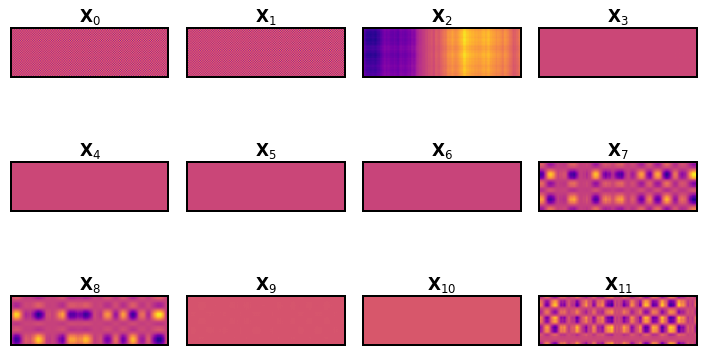

In [11]:
n = min(12, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

### Paso 3: promedio diagonal

Idealmente las matrices obtenidas deberías ser simetricas respecto de la diagonal (como X). Como no lo son, se hará un promedio diagonal, y asi substraer una serie temporal de cada uno. Esto se hará con la función Hankelise(), cuyo nombre se refiere al tipo de matriz obtenida. 

In [12]:
# Vemos graficamente que sucede
#n = min(d, 16)
#for j in range(0,n):
#    plt.subplot(4,4,j+1)
#    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
#    plot_2d(Hankelise(X_elem[j]), title)
#plt.tight_layout() 

### Construcción serie temporal

Se construirán las primeras 12 componentes

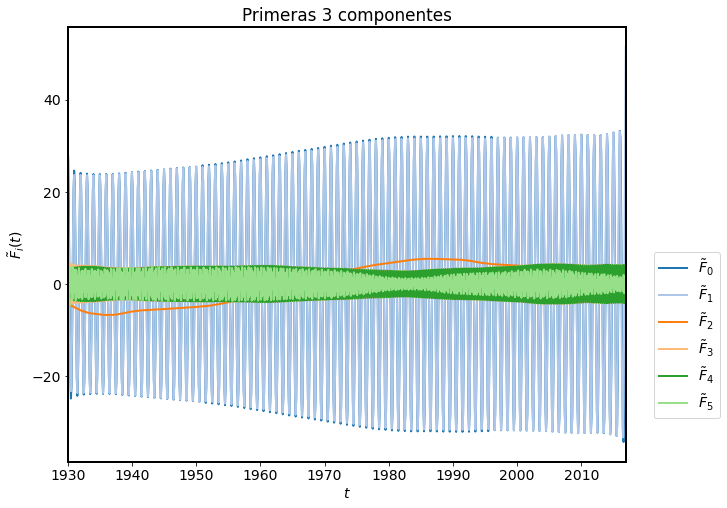

In [13]:
n = min(6,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.figure()
ax = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
ax.axes.set_prop_cycle(color_cycle)

t = pp_anom_PromReg.index

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    ax.axes.plot(t, F_i, lw=2)

#fig.axes.plot(t, pp_anom_PromReg, alpha=1, lw=1, color = 'pink')
ax.set_xlabel("$t$")
ax.set_ylabel(r"$\tilde{F}_i(t)$")
ax.set_xlim(t[0], t[-1])
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
ax.set_title("Primeras 3 componentes")
   
ax.legend(legend, loc=(1.05,0.1));

fig.savefig(SALIDAS + 'SSA_3componentes_PPMensual'+PER+".jpg", dpi=300, bbox_inches='tight')



### Contribución de cada componente

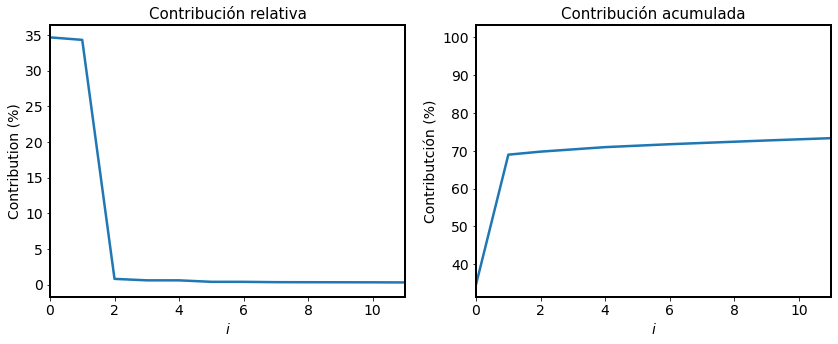

In [14]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Contribución relativa", size=15)
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Contribución acumulada", size=15)
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contributción (%)");

fig.savefig(SALIDAS + 'Contribución_PPMensual'+PER+".jpg", dpi=300, bbox_inches='tight')

### Matriz de correlación
Se busca ver que tan ortogonales son las componentes entre sí, es decir, si son independientes una de otra. La matriz Wij permite ver la correlación entre ellas. Si es mayor a 0,3 deben considerarse dependientes entre sí.

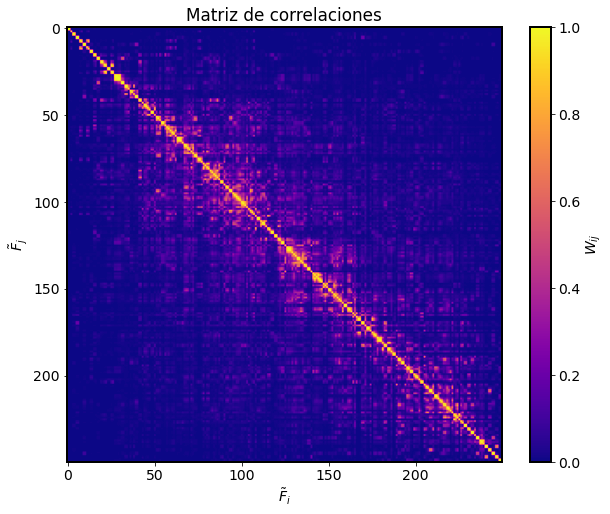

In [15]:
# Get the weights w first, as they'll be reused a lot.
# Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w), 
# [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
# list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
# Add all the lists together and we have our array of weights.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

#Plot
fig = plt.figure()
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("Matriz de correlaciones");

fig.savefig(SALIDAS + 'Matriz_Correlaciones_PPMensual'+PER+".jpg", dpi=300, bbox_inches='tight')

### Periodograma de la serie temporal

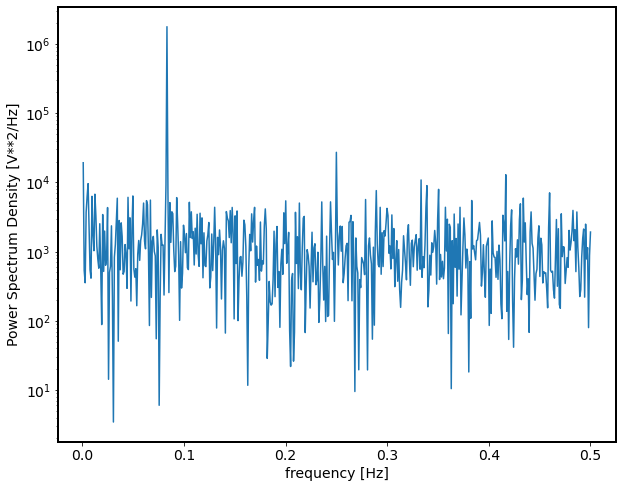

In [16]:
f, pwr = signal.periodogram(pp_anom_PromReg['precip'])


plt.semilogy(f[1:], pwr[1:])
#plt.xlim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('Power Spectrum Density [V**2/Hz]')
plt.show()

## Datos anuales

87
El valor de Sigma es: [1873.9768  1343.426   1266.7876  1207.7495  1153.9429   921.8989
  875.92664  869.7779   854.2732   726.1948   721.9892   655.2754
  575.9535   562.37274  546.97546]


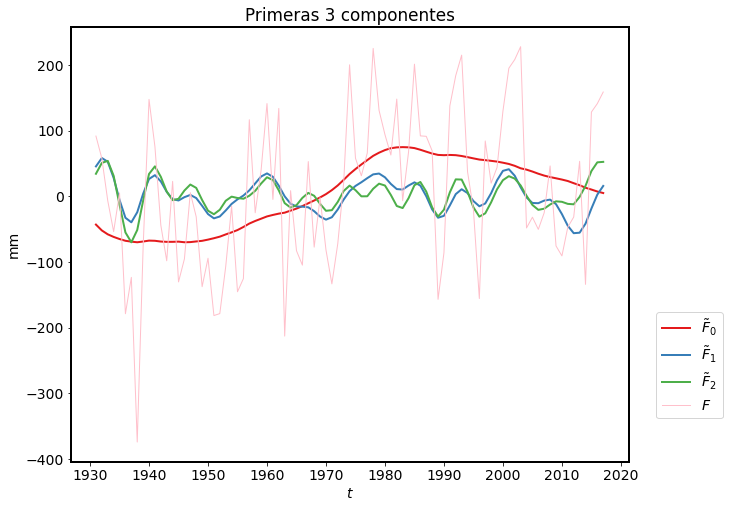

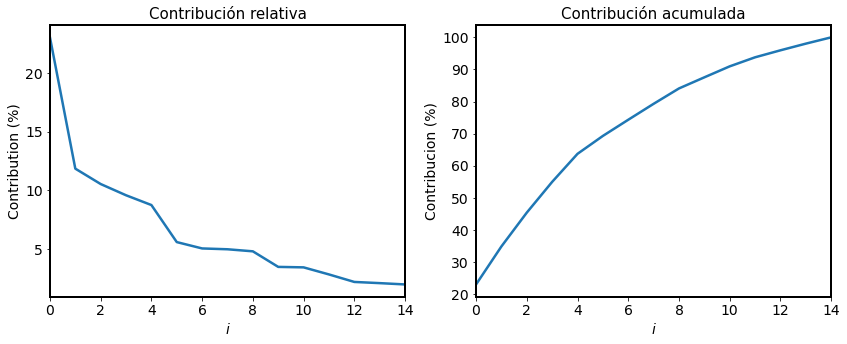

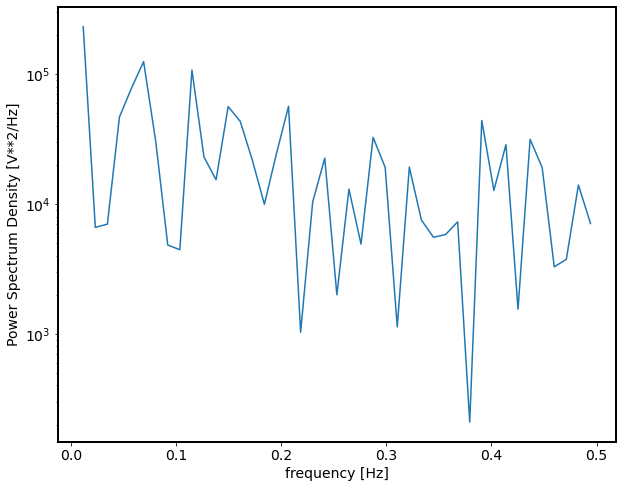

In [17]:
#Tomo los datos de verano del diccionario
pp = pp_ann_anom_PromReg

#Extraigo N como la cantidad total de fechas
N = len(pp)
print(N)
#Tamaño de la ventana
L = 15
K = N - L + 1

X_est = np.column_stack([pp[i:i+L] for i in range(0,K)])

d = np.linalg.matrix_rank(X_est) # The intrinsic dimensionality of the trajectory space.

U, Sigma, V = np.linalg.svd(X_est)

print("El valor de Sigma es: {}".format(Sigma))

V = V.T 

X_elem_est = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X_est, X_elem_est.sum(axis=0), atol=1e-4):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

n = min(3,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.figure()
ax = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('Set1').colors)
ax.axes.set_prop_cycle(color_cycle)

t = pp.index

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem_est[i])
    ax.axes.plot(t, F_i, lw=2)

ax.axes.plot(t, pp, alpha=1, lw=1, color = 'pink')
ax.set_xlabel("$t$")
ax.set_ylabel("mm")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
ax.set_title("Primeras 3 componentes")
ax.legend(legend, loc=(1.05,0.1));

fig.savefig(SALIDAS + 'SSA_'+str(n)+'_componentes_ventana'+str(L)+'_anual.jpg', dpi=300, bbox_inches='tight')

#############################################################

#Contribución de cada componetne
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,14)
ax[0].set_title("Contribución relativa", size=15)
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,14)
ax[1].set_title("Contribución acumulada", size=15)
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribucion (%)");

fig.savefig(SALIDAS + 'contribución_ventana_'+str(L)+'_anual.jpg', dpi=300, bbox_inches='tight')

####################################################

#Matriz de correlación
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem_est = np.array([X_to_TS(X_elem_est[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem_est[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem_est[i]*F_elem_est[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

#Plot
fig = plt.figure()
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("Matriz de correlaciones");
fig.savefig(SALIDAS + 'matriz_correlaciones_ventana_'+str(L)+'_anual.jpg', dpi=300, bbox_inches='tight')
plt.clf()

#############################################

#Periodograma
f, pwr = signal.periodogram(pp['precip'])

plt.semilogy(f[1:], pwr[1:])
plt.xlabel('frequency [Hz]')
plt.ylabel('Power Spectrum Density [V**2/Hz]')
plt.show()

## Datos estacionales 

86
El valor de Sigma es: [1131.1776   731.85376  725.07574  711.6964   706.089    643.6314
  599.208    548.5619   515.8667   486.89597  466.0109   459.35846
  457.06073  409.44806  387.8917 ]


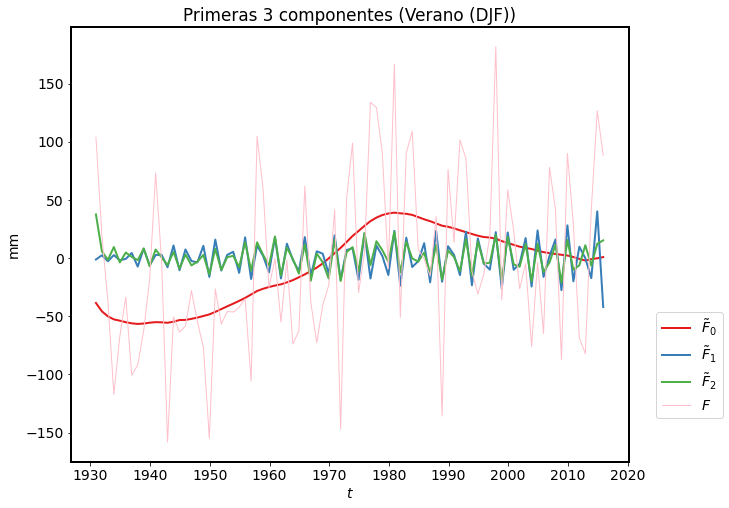

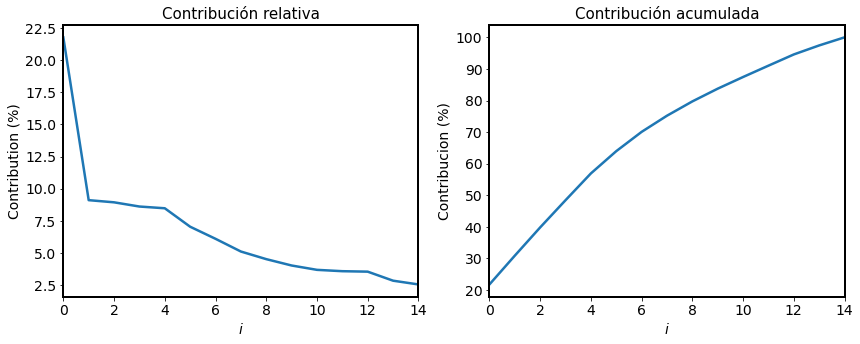

<Figure size 720x576 with 0 Axes>

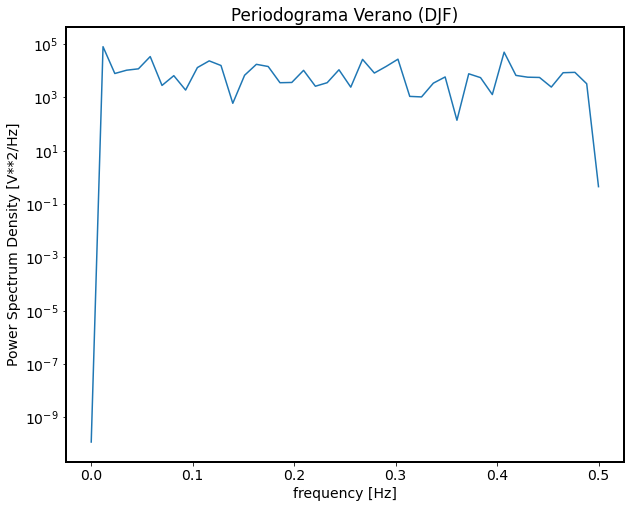

87
El valor de Sigma es: [682.03845 645.20197 633.4406  582.89386 567.86804 463.0304  448.35928
 435.9202  400.0294  398.57996 353.84232 336.06778 317.79053 290.5437
 283.60056]


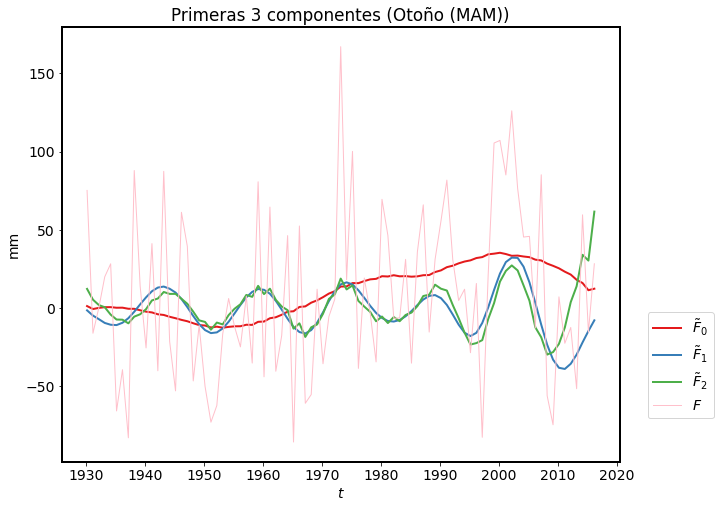

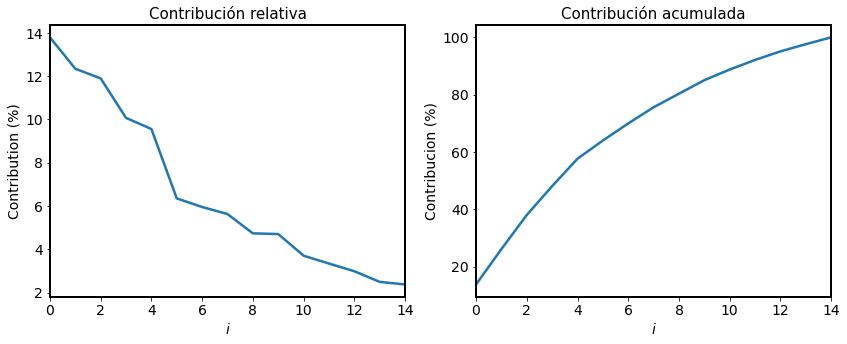

<Figure size 720x576 with 0 Axes>

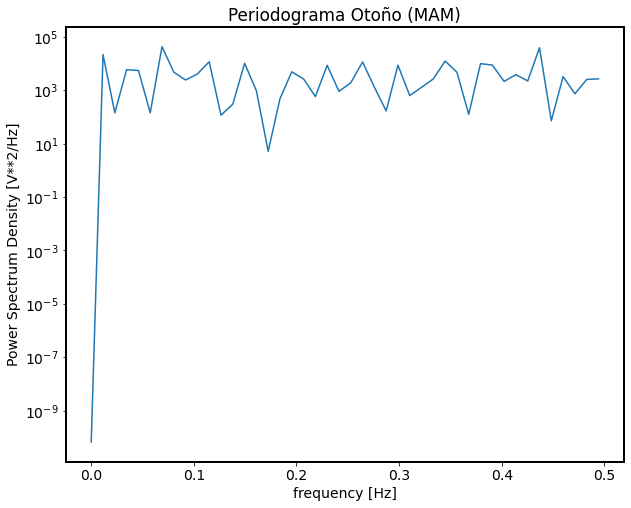

87
El valor de Sigma es: [261.4747  250.97296 243.17323 237.27759 233.52643 223.50687 207.13043
 189.94081 186.69267 169.46516 164.20854 161.49487 155.7434  138.61888
 132.63585]


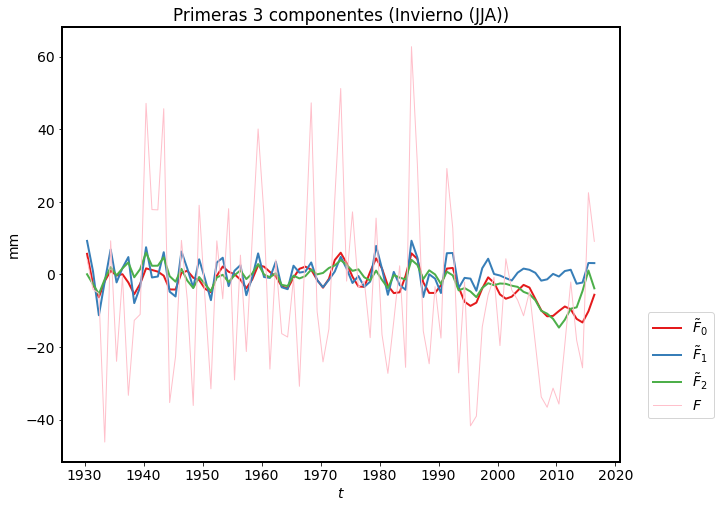

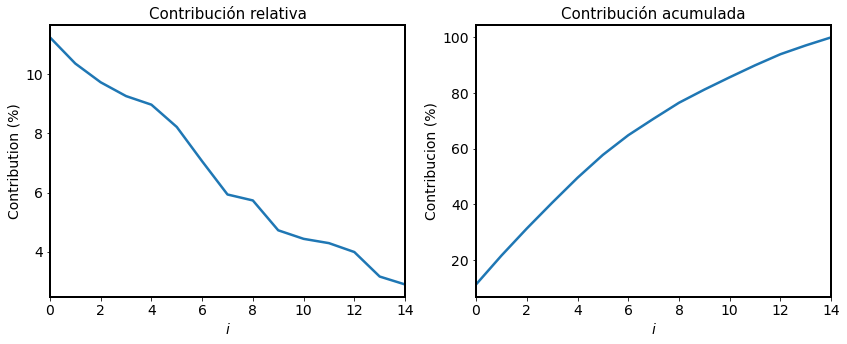

<Figure size 720x576 with 0 Axes>

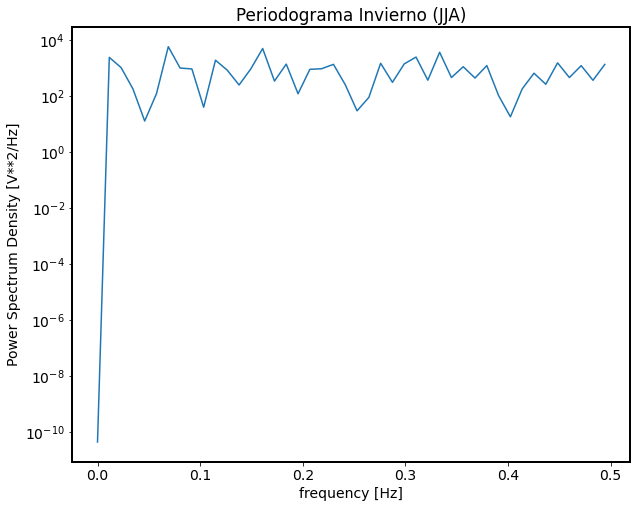

87
El valor de Sigma es: [512.0163  508.31848 481.94058 474.60056 425.19403 417.80225 394.25406
 393.2291  385.21652 370.08252 359.91287 349.8468  321.6672  298.46
 291.4553 ]


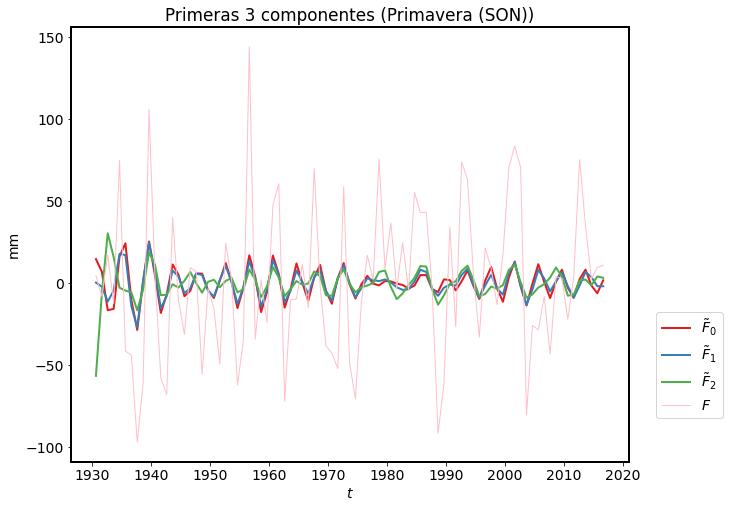

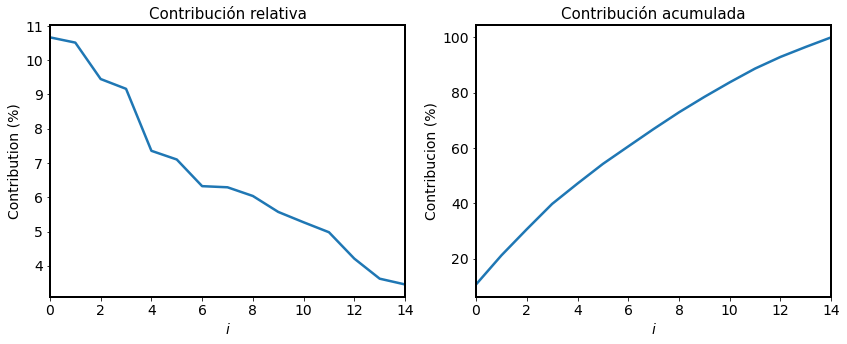

<Figure size 720x576 with 0 Axes>

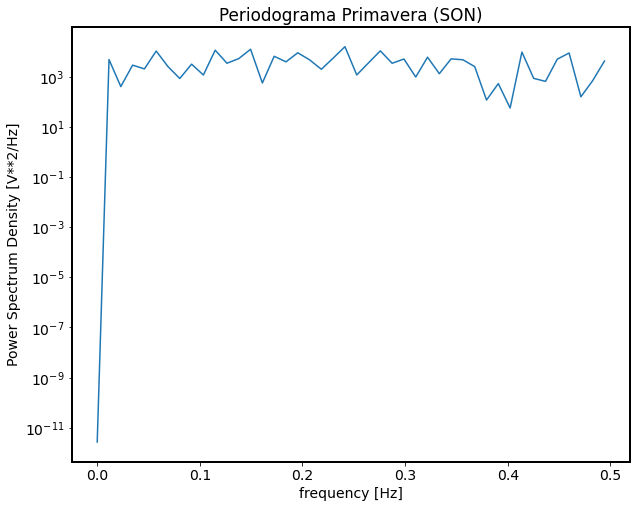

In [18]:
for key in KEYS:
    
    #Tomo los datos de verano del diccionario
    pp = pp_anom_est_PromReg[key]

    #Extraigo N como la cantidad total de fechas
    N = len(pp)
    print(N)
    #Tamaño de la ventana
    L = 15
    K = N - L + 1

    X_est = np.column_stack([pp[i:i+L] for i in range(0,K)])

    d = np.linalg.matrix_rank(X_est) # The intrinsic dimensionality of the trajectory space.

    U, Sigma, V = np.linalg.svd(X_est)
    
    print("El valor de Sigma es: {}".format(Sigma))
    
    V = V.T 

    X_elem_est = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

    if not np.allclose(X_est, X_elem_est.sum(axis=0), atol=1e-4):
        print("WARNING: The sum of X's elementary matrices is not equal to X!")

    n = min(3,d) # In case of noiseless time series with d < 12.

    # Fiddle with colour cycle - need more colours!
    fig = plt.figure()
    ax = plt.subplot()
    color_cycle = cycler(color=plt.get_cmap('Set1').colors)
    ax.axes.set_prop_cycle(color_cycle)

    t = pp.index

    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    for i in range(n):
        F_i = X_to_TS(X_elem_est[i])
        ax.axes.plot(t, F_i, lw=2)

    ax.axes.plot(t, pp, alpha=1, lw=1, color = 'pink')
    ax.set_xlabel("$t$")
    ax.set_ylabel("mm")
    legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
    ax.set_title("Primeras 3 componentes ("+key+')')
    ax.legend(legend, loc=(1.05,0.1));

    fig.savefig(SALIDAS + 'SSA_'+str(n)+'_componentes_ventana'+str(L)+'_'+key+".jpg", dpi=300, bbox_inches='tight')
    
    #############################################################
    
    #Contribución de cada componetne
    sigma_sumsq = (Sigma**2).sum()
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
    ax[0].set_xlim(0,14)
    ax[0].set_title("Contribución relativa", size=15)
    ax[0].set_xlabel("$i$")
    ax[0].set_ylabel("Contribution (%)")
    ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
    ax[1].set_xlim(0,L-1)
    ax[1].set_title("Contribución acumulada", size=15)
    ax[1].set_xlabel("$i$")
    ax[1].set_ylabel("Contribucion (%)");

    fig.savefig(SALIDAS + 'contribución_ventana_'+str(L)+'_'+key+".jpg", dpi=300, bbox_inches='tight')
    
    ####################################################
    
    #Matriz de correlación
    w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

    # Get all the components of the toy series, store them as columns in F_elem array.
    F_elem_est = np.array([X_to_TS(X_elem_est[i]) for i in range(d)])

    # Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
    F_wnorms = np.array([w.dot(F_elem_est[i]**2) for i in range(d)])
    F_wnorms = F_wnorms**-0.5

    # Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
    # and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
    Wcorr = np.identity(d)
    for i in range(d):
        for j in range(i+1,d):
            Wcorr[i,j] = abs(w.dot(F_elem_est[i]*F_elem_est[j]) * F_wnorms[i] * F_wnorms[j])
            Wcorr[j,i] = Wcorr[i,j]

    #Plot
    fig = plt.figure()
    ax = plt.imshow(Wcorr)
    plt.xlabel(r"$\tilde{F}_i$")
    plt.ylabel(r"$\tilde{F}_j$")
    plt.colorbar(ax.colorbar, fraction=0.045)
    ax.colorbar.set_label("$W_{ij}$")
    plt.clim(0,1)
    plt.title("Matriz de correlaciones");
    fig.savefig(SALIDAS + 'matriz_correlaciones_ventana_'+str(L)+'_'+key+".jpg", dpi=300, bbox_inches='tight')
    plt.clf()
    
    ##################################################################3
    #Periodograma
    
    fig = plt.figure()
    f, pwr = signal.periodogram(pp['precip'])

    plt.semilogy(f, pwr)
    plt.title('Periodograma '+str(key))
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Power Spectrum Density [V**2/Hz]')
    plt.show()

    #fig.savefig(SALIDAS + 'matriz_correlaciones_ventana_'+str(L)+'_'+key+".jpg", dpi=300, bbox_inches='tight')
    

## Correlaciones

### Lectura y arreglo de datos de sst, geop, slp

####  SST

In [19]:
# Abro el archivo usando xarray
ds_tsm=xr.open_dataset(DATOS_SST)
#Recorte temporal
tsm_recorte = ds_tsm.sel(time=slice(TIMEMIN,TIMEMAX))['sst']

#Agrupando por meses, le resto la media climatologica mensual a los datos. Asi
#obtengo anomalías de tsm. 
tsm_anom=tsm_recorte.groupby('time.month')-tsm_recorte.groupby('time.month').mean('time')


#Remuestreo de los datos por estación (DJF-MAM-JJA-SON)
tsm_anom_est=tsm_anom.resample(time='QS-DEC').mean()

#Guardo los datos separados por estación en un diccionario
tsm_anom_est={KEYS[0]:tsm_anom.sel(time=tsm_anom["time.month"]==12),
              KEYS[1]:tsm_anom.sel(time=tsm_anom["time.month"]==3),
              KEYS[2]:tsm_anom.sel(time=tsm_anom["time.month"]==6),
              KEYS[3]:tsm_anom.sel(time=tsm_anom["time.month"]==9)}
 

#Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
tsm_anom_est[KEYS[0]]=tsm_anom_est[KEYS[0]].sel(time=slice(tsm_anom_est[KEYS[0]]['time'][0],
                                                           tsm_anom_est[KEYS[0]]['time'][-2]))

del ds_tsm, tsm_anom, tsm_recorte


#### Geopotencial

In [20]:
# Anomalías de geopotencial

#Hemisferio sur
LAT_NOR_HS=2
LAT_SUR_HS=-90

# Abro el archivo usando xarray
ds_geo=xr.open_dataset(DATOS_GEOP)

alts = [200,500,850]
geops = []



for alt in alts:

    # Recorte espacial temporal
    geo_recorte = ds_geo.sel(time=slice(TIMEMIN,TIMEMAX), latitude=slice(LAT_NOR_HS, LAT_SUR_HS))['z'].sel(level=alt)

    # #Agrupando por meses, le resto la media climatologica mensual a los datos. Asi
    # #obtengo anomalías de tsm. 
    geo_anom=geo_recorte.groupby('time.month')-geo_recorte.groupby('time.month').mean('time')

    #Remuestreo de los datos por estación (DJF-MAM-JJA-SON)
    geo_anom_est=geo_anom.resample(time='QS-DEC').mean()

    #Guardo los datos separados por estación en un diccionario
    geo_anom_est={KEYS[0]:geo_anom.sel(time=geo_anom["time.month"]==12),
                  KEYS[1]:geo_anom.sel(time=geo_anom["time.month"]==3),
                  KEYS[2]:geo_anom.sel(time=geo_anom["time.month"]==6),
                  KEYS[3]:geo_anom.sel(time=geo_anom["time.month"]==9)}


    #Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
    geo_anom_est[KEYS[0]]=geo_anom_est[KEYS[0]].sel(time=slice(geo_anom_est[KEYS[0]]['time'][0],
                                                                geo_anom_est[KEYS[0]]['time'][-1]))
    
    geops.append(geo_anom_est)

    del geo_anom, geo_recorte

geo200_anom_est = geops[0]
geo500_anom_est = geops[1]
geo850_anom_est = geops[2] 

del geops, ds_geo

#### Presión media a nivel del mar

In [21]:
# Abro el archivo usando xarray
ds_mslp=xr.open_dataset(DATOS_MSLP)

#Recorte espacial y temporal
mslp_recorte = ds_mslp.sel(time=slice(TIMEMIN,TIMEMAX), latitude=slice(LAT_NOR_HS, LAT_SUR_HS))['msl']


#Agrupando por meses, le resto la media climatologica mensual a los datos. Asi
#obtengo anomalías de mslp. 
mslp_anom=mslp_recorte.groupby('time.month')-mslp_recorte.groupby('time.month').mean('time')


#Remuestreo de los datos por estación (DJF-MAM-JJA-SON)
mslp_anom_est=mslp_anom.resample(time='QS-DEC').mean()

#Guardo los datos separados por estación en un diccionario
mslp_anom_est={KEYS[0]:mslp_anom.sel(time=mslp_anom["time.month"]==12),
               KEYS[1]:mslp_anom.sel(time=mslp_anom["time.month"]==3),
               KEYS[2]:mslp_anom.sel(time=mslp_anom["time.month"]==6),
               KEYS[3]:mslp_anom.sel(time=mslp_anom["time.month"]==9)}
 

#Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
mslp_anom_est[KEYS[0]]=mslp_anom_est[KEYS[0]].sel(time=slice(mslp_anom_est[KEYS[0]]['time'][0],
                                                            mslp_anom_est[KEYS[0]]['time'][-1]))

del ds_mslp, mslp_anom, mslp_recorte

### Obtención de series temporales de componentes 1-5

In [22]:
ssa_components = {}

for key in KEYS:
    
    #Tomo los datos de verano del diccionario
    pp = pp_anom_est_PromReg[key]

    #Extraigo N como la cantidad total de fechas
    N = len(pp)
    print(N)
    #Tamaño de la ventana
    L = 25
    K = N - L + 1

    X_est = np.column_stack([pp[i:i+L] for i in range(0,K)])

    d = np.linalg.matrix_rank(X_est) # The intrinsic dimensionality of the trajectory space.

    U, Sigma, V = np.linalg.svd(X_est)

    V = V.T 

    X_elem_est = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

    if not np.allclose(X_est, X_elem_est.sum(axis=0), atol=1e-4):
        print("WARNING: The sum of X's elementary matrices is not equal to X!")

    n = min(3,d) # In case of noiseless time series with d < 12.

    t = pp.index

    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.

    tseries = []

    for i in range(n):
        F_i = X_to_TS(X_elem_est[i])
        print(F_i)
        tseries.append(F_i)
        
    ssa_components[key]=tseries
    
    del tseries

    



86
[-48.550903  -56.253212  -61.32076   -63.352814  -63.21407   -62.504757
 -61.813637  -60.735943  -59.024162  -57.15677   -55.70929   -55.05534
 -54.567924  -53.373577  -52.08217   -50.725708  -49.20956   -47.963406
 -46.596813  -45.02595   -42.938828  -40.730103  -38.39331   -35.905594
 -33.349186  -31.377592  -29.113281  -26.63451   -24.335854  -22.205128
 -20.032677  -17.781916  -15.497127  -13.2342415 -10.909504   -8.390105
  -5.9360743  -3.3549345  -0.647431    2.0755816   4.757338    7.3528094
  10.214115   13.002811   15.462986   17.817347   20.034025   21.813044
  23.200998   24.244087   25.144567   25.50876    25.788904   25.888779
  25.66865    25.372248   25.0423     24.663132   24.098137   23.690004
  23.188671   22.722345   22.355799   21.712042   20.959114   20.083132
  19.17328    18.136593   17.008753   15.973259   14.906628   13.9119
  12.975802   12.030114   11.259269   10.577659   10.184424    9.595642
   9.195797    8.9363165   8.503652    7.8721786   7.52205     

## Correlación con primera componente 

### Paso de lista a xarray las componentes de ssa

In [23]:
for key in KEYS:
    
    for i in range(len(ssa_components[key])):
        
        #Extraigo serie temporal
        ts = ssa_components[key][i]
        
        #Obtengo eje temporal de la serie original de precipitación
        t = pp_anom_est_PromReg[key].index
        
        #Armo data array 
        da = xr.DataArray(data = ts, dims=['time'], coords={'time':t})
        
        ssa_components[key][i] = da

In [24]:
#Precipitación + sst
corr_c1_sst = xr_corr(tsm_anom_est, ssa_components, 0)
#Precipitación + geopotencial
corr_c1_geo200 = xr_corr(geo200_anom_est, ssa_components, 0)
corr_c1_geo500 = xr_corr(geo500_anom_est, ssa_components, 0)
corr_c1_geo850 = xr_corr(geo850_anom_est, ssa_components, 0)
#Precipitación + mslp
corr_c1_mslp = xr_corr(mslp_anom_est, ssa_components, 0)
    

## Mapas mostrando la correlación
Para las variables geopotencial y presión media a nivel del mar se usa una proyección estereográfica centrada en el Polo Sur. Para la temperatura de la superficie del mar se usa proyección Robinson. 

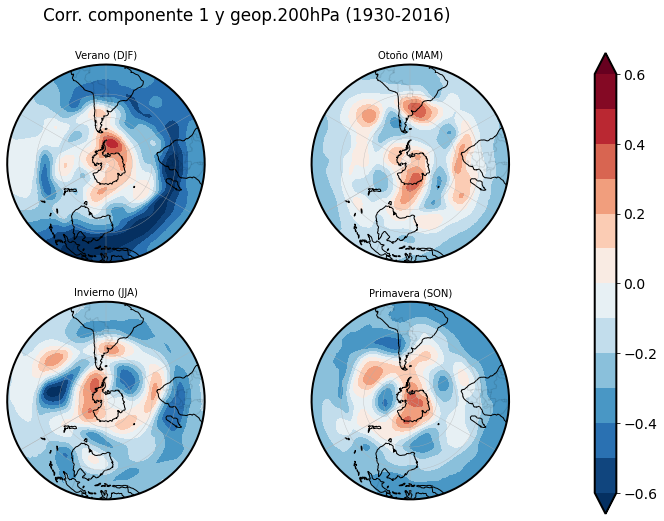

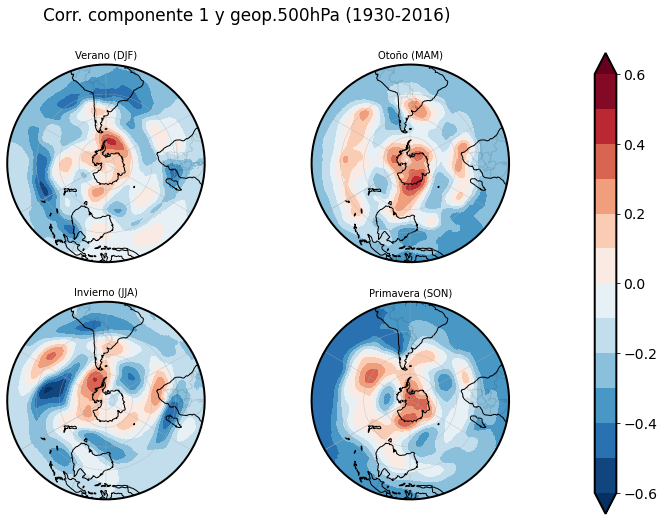

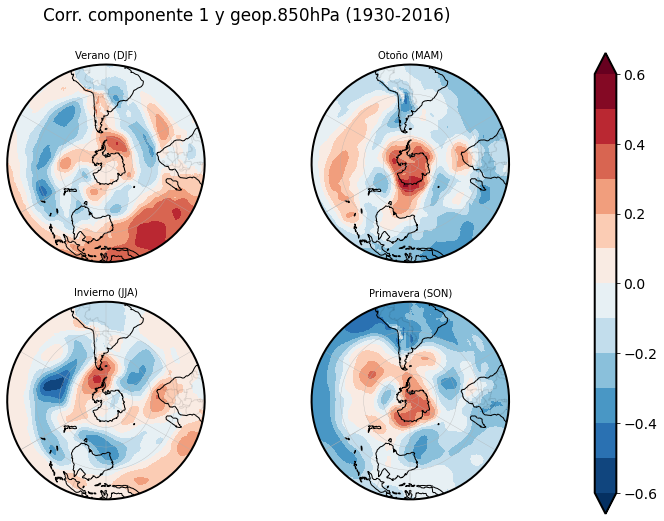

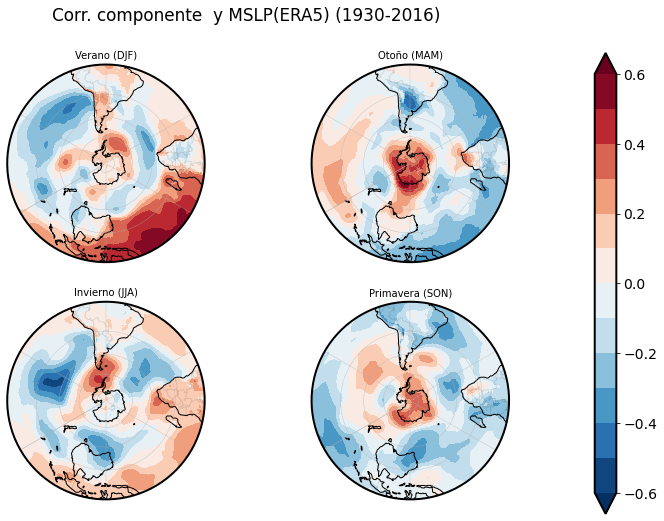

In [25]:
# Precipitación + geopotencial
graf_corrs_stereo(corr_c1_geo200, 'geop.200hPa', '1')
graf_corrs_stereo(corr_c1_geo500, 'geop.500hPa', '1')
graf_corrs_stereo(corr_c1_geo850, 'geop.850hPa', '1')

#Precipitación + presión
graf_corrs_stereo(corr_c1_mslp, 'MSLP(ERA5)')

Figura de correlacion_TSM_PP(CRU)_SinTendencia(1930-2016) en /home/dalia.panza/Proy_IAI/Salidas/SSA/


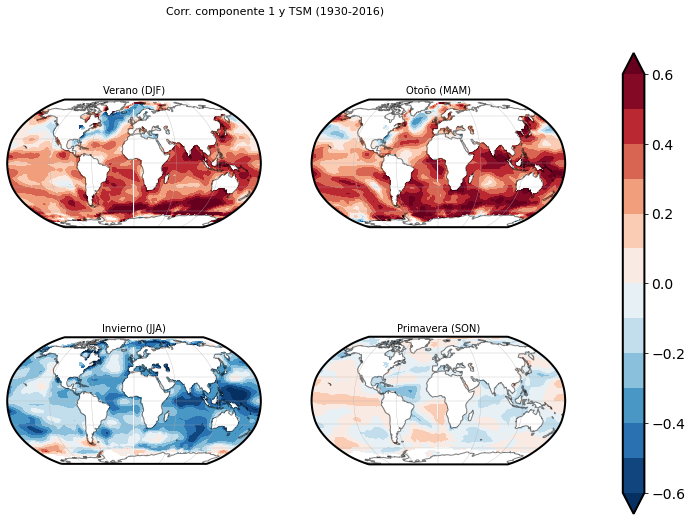

In [26]:
#Precipitación + tsm
graf_corrs_Robinson(corr_c1_sst, 'TSM', "1")

## Correlaciones componentes verano

In [27]:
key = 'Verano (DJF)'

ssa = ssa_components[key]